# Week 3 : Genetic Programming
```
- Nature Inspired Computing
```
<hr>


```
Lab Plan
1. Recap (Genetic Algorithms)
2. Recap (Genetic Programming)
3. Regression using genetic programming
4. Classification using genetic programming
5. Self practice task
```

<hr>


## 1. Genetic Algorithms (Recap)

Key points about GA with a figure

![GA steps](https://www.tutorialspoint.com/genetic_algorithms/images/basic_structure.jpg)

## 2. Genetic Programming (Recap)

> Genetic algorithms are powerful optimization techniques, but they have
> an inherent limitation: they incorporate the assumed solution structure in
> the representation of their candidate solutions.
> For instance, if we want to use a GA to solve a problem with 10 variables,
> then the GA chromosome is typically represented as $(x_1, x_2, · · ·, x_{10})$·
> This can be a disadvantage for GAs when we don't not know which parameters
> need to be optimized in a given problem. Also, we may not know the structure
> of the parameters that need to be optimized. Are the parameters real numbers,
> or state space machines, or computer programs, or complex arrays, or time
> schedules, or something else?"
>
> -- Evolutionary Optimization Algorithms(book)

GP is an EA approach that trys not only to learn the best parameter to a fixed
structure, but to lean the best structure to represent the problem.

![Genetic programming tree](https://upload.wikimedia.org/wikipedia/commons/f/f9/Genetic_programming_mutation.gif?20210608182634)


Based on [this](https://github.com/trevorstephens/gplearn/blob/main/doc/gp_examples.ipynb)

In [1]:
!pip install gplearn

In [2]:
%matplotlib inline
from gplearn.genetic import SymbolicRegressor, SymbolicClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import graphviz

## 3. Regression using Genetic Programming

Let's consider the following problem: $$ F(X_0,X_1) = X_0^2 -X_1^2 + X_0 - 1$$

Remember from Introduction to Machine Learning that if we use linear regression, we can't fit this function properly, because LR assumes a linear relation, and to solve that we had to generate polynomial features ourselves.

(20,)
(20, 20)


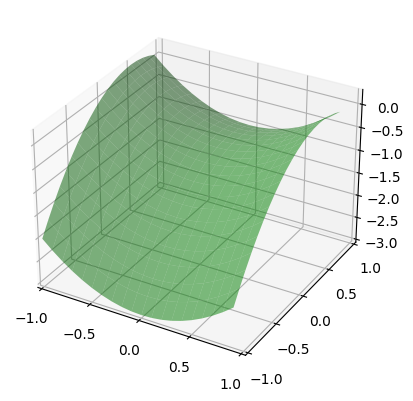

In [3]:
# Ground truth

x0 = np.arange(-1, 1, .1)
x1 = np.arange(-1, 1, .1)
print(x1.shape)
x0, x1 = np.meshgrid(x0, x1)
print(x1.shape)
Fx = x0**2 - x1**2 + x1 - 1

def plot_data(x0, x1, Fx):
    ax = plt.figure().add_subplot(projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xticks(np.arange(-1, 1.01, .5))
    ax.set_yticks(np.arange(-1, 1.01, .5))
    surf = ax.plot_surface(x0, x1, Fx, rstride=1, cstride=1, color='green', alpha=0.5)
    plt.show()


plot_data(x0, x1, Fx)

### Problem Dataset

In [4]:
rng = check_random_state(0)

# Training samples
X_train = rng.uniform(-1, 1, 100).reshape(50, 2)
y_train = X_train[:, 0]**2 - X_train[:, 1]**2 + X_train[:, 1] - 1
y_train = y_train + np.random.randn(*y_train.shape) * 0.05 # added noise

# Testing samples
X_test = rng.uniform(-1, 1, 100).reshape(50, 2)
y_test = X_test[:, 0]**2 - X_test[:, 1]**2 + X_test[:, 1] - 1

### Solution 1

Lets try to use simple Machine Learning models to solve the problem
* What is the main approach used by most ML algorithmns: Gradient Descent

Lets try to fit simple Linear regression and Polynomial regression

In [5]:
# Your code here
from sklearn.linear_model import LinearRegression
# Fit Linear regression model
linear_regression =  LinearRegression().fit(X_train, y_train)


# Train a polynomial regression model with degree = 2
poly = PolynomialFeatures(3)
polynomial_regression = LinearRegression()
polynomial_regression.fit(poly.fit_transform(X_train),y_train)
print(poly.fit_transform(X_train))

[[ 1.00000000e+00  9.76270079e-02  4.30378733e-01  9.53103266e-03
   4.20165879e-02  1.85225854e-01  9.30486201e-04  4.10195376e-03
   1.80830459e-02  7.97172681e-02]
 [ 1.00000000e+00  2.05526752e-01  8.97663660e-02  4.22412458e-02
   1.84493897e-02  8.05800046e-03  8.68170607e-03  3.79184313e-03
   1.65613466e-03  7.23337419e-04]
 [ 1.00000000e+00 -1.52690401e-01  2.91788226e-01  2.33143587e-02
  -4.45532613e-02  8.51403689e-02 -3.55987878e-03  6.80285536e-03
  -1.30001171e-02  2.48429572e-02]
 [ 1.00000000e+00 -1.24825577e-01  7.83546002e-01  1.55814248e-02
  -9.78065821e-02  6.13944337e-01 -1.94496035e-03  1.22087631e-02
  -7.66359563e-02  4.81053630e-01]
 [ 1.00000000e+00  9.27325521e-01 -2.33116962e-01  8.59932622e-01
  -2.16175309e-01  5.43435181e-02  7.97437467e-01 -2.00464881e-01
   5.03941313e-02 -1.26683959e-02]
 [ 1.00000000e+00  5.83450076e-01  5.77898395e-02  3.40413991e-01
   3.37174863e-02  3.33966555e-03  1.98614569e-01  1.96724699e-02
   1.94852812e-03  1.92998736e-04

### Solution 2 (GP)

Lets try to use genetic programming based algorithm

* What are the main componets that we need to define for GP algorithm?

We will use Symbolic Regressor

> Symbolic regression is a machine learning technique that aims to identify an underlying mathematical expression that best describes a relationship. It begins by building a population of naive random formulas to represent a relationship between known independent variables and their dependent variable targets in order to predict new data. Each successive generation of programs is then evolved from the one that came before it by selecting the fittest individuals from the population to undergo genetic operations.

In [6]:
genetic_pr_model = SymbolicRegressor(population_size=5000,
                                     generations=20, stopping_criteria=0.01,
                                     p_crossover=0.7, p_subtree_mutation=0.1,
                                     p_hoist_mutation=0.05, p_point_mutation=0.1,
                                     max_samples=0.9, verbose=1,
                                     parsimony_coefficient=0.01, random_state=0)
genetic_pr_model.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13          458.575        5         0.320741          0.56452      4.27m
   1     9.94          1.69636        5         0.320345         0.645297      2.88m
   2     7.71          1.94305       11         0.240951         0.501265      2.41m
   3     5.39          0.98867        7         0.235416         0.728261      1.01m
   4     4.69         0.879221       11         0.101969        0.0906127      1.02m
   5     6.07         0.944839       11        0.0590697        0.0695262     49.73s
   6     7.16          1.10341       11        0.0584545        0.0750631     45.61s
   7     7.42          1.82325       11        0.0576225        0.0825505      1.01m
   8     7.78          1.06376       11        0.0555203         0.101471  

SymbolicRegressor(max_samples=0.9, p_crossover=0.7, p_hoist_mutation=0.05,
                  p_point_mutation=0.1, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.01, verbose=1)

### Visualize Best GP solution (program)

In [7]:
x1.shape

(20, 20)

Program : sub(sub(X1, 0.978), mul(sub(X1, X0), add(X0, X1)))


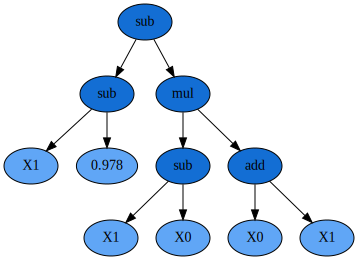

In [8]:
print("Program :",genetic_pr_model._program)
dot_data = genetic_pr_model._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

### Compare Solutions

In [9]:
np.c_[x0.ravel(),x1.ravel()].shape

(400, 2)

In [10]:
y_gp = genetic_pr_model.predict(np.c_[x0.ravel(),x1.ravel()]).reshape(x0.shape) # Task: predict Fx using the GP regression model (the model input - X0 and X1 from the initial problem)
score_gp = genetic_pr_model.score(X_test,y_test) # Task: Evaluate the model performance on testset (xtest)

y_lr = linear_regression.predict(np.c_[x0.ravel(),x1.ravel()]).reshape(x0.shape) # Task: predict Fx using the linear regression model (the model input - X0 and X1 from the initial problem)
score_lr = linear_regression.score(X_test,y_test) # Task: Evaluate the model performance on testset (xtest)


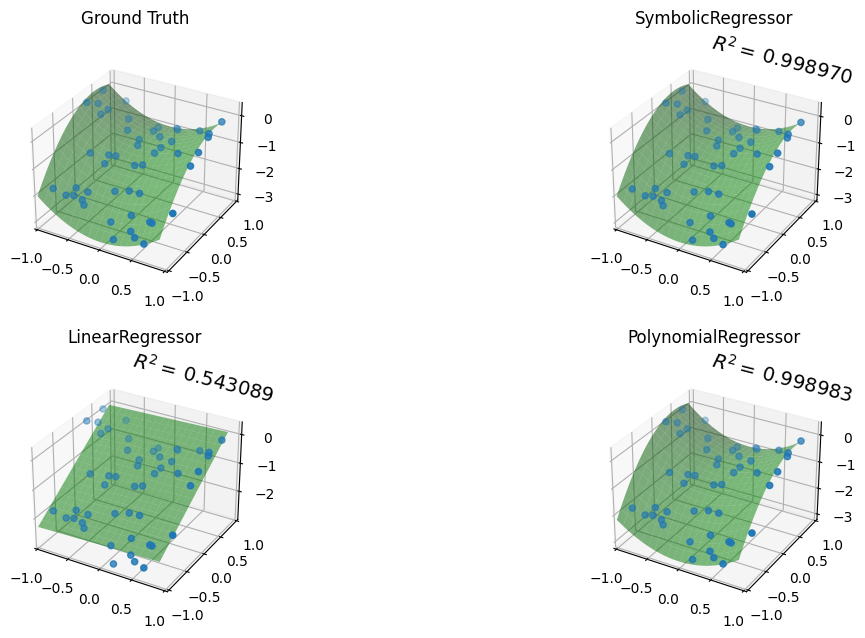

In [11]:
y_gp = genetic_pr_model.predict(np.c_[x0.ravel(),x1.ravel()]).reshape(x0.shape) # Task: predict Fx using the GP regression model (the model input - X0 and X1 from the initial problem)
score_gp = genetic_pr_model.score(X_test,y_test) # Task: Evaluate the model performance on testset (xtest)

y_lr = linear_regression.predict(np.c_[x0.ravel(),x1.ravel()]).reshape(x0.shape) # Task: predict Fx using the linear regression model (the model input - X0 and X1 from the initial problem)
score_lr = linear_regression.score(X_test,y_test) # Task: Evaluate the model performance on testset (xtest)

y_pr = polynomial_regression.predict(poly.fit_transform(np.c_[x0.ravel(),x1.ravel()])).reshape(x0.shape) # Task: predict Fx using the polynomial regression model (the model input - X0 and X1 from the initial problem)
score_pr = polynomial_regression.score(poly.fit_transform(X_test),y_test) # Task: Evaluate the model performance on testset (xtest)

models_stats = [
    (Fx, None, "Ground Truth"),
    (y_gp, score_gp, "SymbolicRegressor"),
    (y_lr, score_lr, "LinearRegressor"),
    (y_pr, score_pr, "PolynomialRegressor"),
]


fig = plt.figure(figsize=(12, 10))
for i, (y, score, title) in enumerate(models_stats):

    ax = fig.add_subplot(3, 2, i+1, projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xticks(np.arange(-1, 1.01, .5))
    ax.set_yticks(np.arange(-1, 1.01, .5))
    surf = ax.plot_surface(x0, x1, y, rstride=1, cstride=1, color='green', alpha=0.5)
    points = ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
    if score is not None:
        score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=14)
    plt.title(title, pad=20)

# using padding
fig.tight_layout(pad=3.0)
plt.show()

## Classification using genetic programming

gplearn also have a classifier and a transformer

### Classification Dataset

We will use cancer detection dataset which is for binary classification

In [12]:
rng = check_random_state(0)
cancer = load_breast_cancer()
perm = rng.permutation(cancer.target.size)
cancer.data = cancer.data[perm]
cancer.target = cancer.target[perm]

### The Classification model with GP

We can limit the allowed functions that GP uses, or exted them with our own

Task: Define a function of your choice that will also be used in the function set

In [13]:
from gplearn.functions import make_function

def f(x1,x2,x3,x4):
    # Write your code here
    return x1*x2*x3*x4

my_function = make_function(function=f,
                            name='my_function',
                            arity=4)

function_set = ['add', 'sub', 'div', my_function]

est = SymbolicClassifier(parsimony_coefficient=.01,
                         feature_names=cancer.feature_names,
                         function_set=function_set,
                         random_state=1)


est.fit(cancer.data[:400], cancer.target[:400])

y_true = cancer.target[400:]
y_score = est.predict_proba(cancer.data[400:])[:,1]
print('ROC AUC score:', roc_auc_score(y_true, y_score))

print('Acc:', est.score(cancer.data[400:], cancer.target[400:]))

ROC AUC score: 0.9859467455621302
Acc: 0.9408284023668639


### Final Best program

sub(div(div(mean smoothness, radius error), my_function(perimeter error, worst concavity, mean texture, mean concave points)), my_function(perimeter error, worst concavity, mean texture, mean concave points))


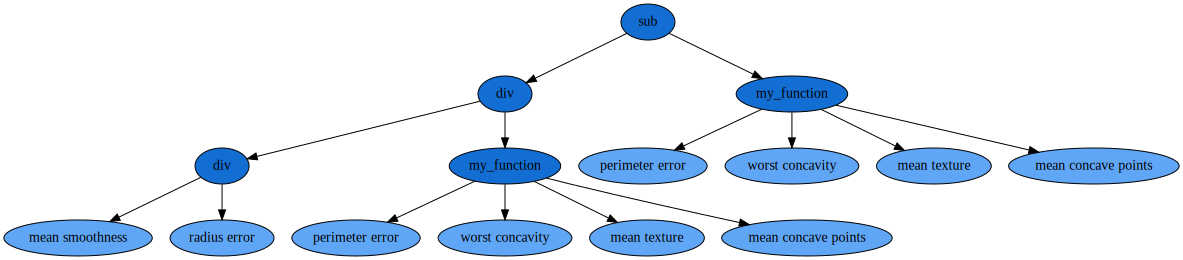

In [14]:
dot_data = est._program.export_graphviz()
graph = graphviz.Source(dot_data)

print(est._program)
graph

### What about categorical data?
We can use ordinal or one hot encoders to encode our categories to numbers.
But, DTs and RF can handle categorical data by making different branch for
each category.

This paper discusses how can we extend GP to support categorical data
> A multi-way branch node which.
>
> A series of ‘if-then-else’.
>
> -- [Genetic Programming for Classification: An Analysis of Convergence Behaviour](https://link.springer.com/chapter/10.1007/3-540-36187-1_27)

# TPOT
![TPOR](https://raw.githubusercontent.com/EpistasisLab/tpot/master/images/tpot-logo.jpg)

Stands for "Tree-based Pipeline Optimization Tool", it's a library that uses GP to
get the best pipeline from sklearn/torch


## Self-practice Task
```
Using TPOT library and dataset of your choice
1. Train a simple classifier
2. Neural network classifier

```

See some examples [here](https://epistasislab.github.io/tpot/examples/)